In [3]:
%pip install yfinance
%pip install matplotlib
%pip install seaborn
%pip install plotly




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Import libraries**

In [4]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.tsa.stattools as ts


# 1. OptiCat Pair Strategy 2024

## OptiCat Idea
In light of the dynamic and interconnected nature of the energy sector, OptiCat has strategically selected a pair trading strategy to navigate the complexities of this market.
Opticat has decided to trade using exclusively energy firms’ stocks due to their high degree of correlation.

## Pair Strategy
The idea behind this technique is to profit on the oscilations of relative growth between two companies.
In order to profit from the relative movements of two positions or assets that are directly or adversely connected, one might use a pair strategy in trading or investing. This include purchasing one stock and selling another at the same time. This strategy's justification is to reduce risk by taking advantage of the anticipated performance difference between the two stocks. For example, if a trader believes that one stock will do better than another, they would go long on the stronger one and short on the weaker one. The effectiveness of a pair strategy depends on carefully examining and analyzing pairs to find those that are most likely to show a notable divergence in their price movements. In order to profit from both upward and downward market movements while limiting exposure to larger market risks, this approach is frequently utilized in market-neutral trading.

## Why the energy sector 
Energy stocks frequently demonstrate a high degree of correlation owing to several shared factors influencing the entire industry. Key among these is the impact of commodity prices, particularly crude oil and natural gas, which significantly affect companies involved in the energy sector. Macroeconomic conditions also play a vital role, with energy demand closely tied to economic growth or contraction. Global events, such as geopolitical tensions or natural disasters, can disrupt energy supply chains and affect multiple companies simultaneously. Regulatory changes, technological advancements, and overall market sentiment further contribute to the correlation within the energy sector.


# 2. Data

# Retrive data

For each stock we extrapolate hourly and daily data from Yahoo Finance based on tickers provided in a list.

## Stock pick

We choose energy sector stocks from **S&P 500** because, as explained previously, in this sector there has been a high correlation in the past. Therefore, we picked the 10 stocks with highest market cap in this sector. 

**STOCK LIST:**
- Exxon Mobil Corporation [XOM]
- Chevron Corporation [CVX]
- ConocoPhillips [COP]
- Schlumberger Limited [SLB]
- EOG Resources, Inc. [EOG]
- Marathon Petroleum Corporation [MPC]
- Phillips 66 [PSX]
- Enterprise Products Partners L.P. [EPD]
- Pioneer Natural Resources Company [PXD]
- Occidental Petroleum Corporation [OXY]




## Hourly data
We get data of our stocks as well as S&P 500 index to be able to compare returns of our strategy against a simple benchmark.

In [5]:
# Companies tickers list
ticker_list=['XOM', 'CVX', 'COP' , 'SLB', 'EOG','MPC', 'PSX', 'EPD', 'PXD', 'OXY', '^GSPC']

# Get data for last 730 days on hounrly time frame
df_hourly = yf.download(ticker_list, period="730d", interval="1h")['Adj Close']

# Rename sp500
df_hourly = df_hourly.rename(columns={'^GSPC':'SP500'})


[*********************100%%**********************]  11 of 11 completed


In [6]:
# Check info of our data frame
df_hourly.info()
print(20*'**'+ '\n')

# Count NaN values in each column
nan_counts_hourly = df_hourly.isna().sum()
display(nan_counts_hourly)
print(20*'**'+ '\n')

# Let's check the index. We want date as index
df_hourly.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5091 entries, 2021-04-14 09:30:00-04:00 to 2024-03-07 12:30:00-05:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     5091 non-null   float64
 1   CVX     5091 non-null   float64
 2   EOG     5069 non-null   float64
 3   EPD     5091 non-null   float64
 4   MPC     5091 non-null   float64
 5   OXY     5091 non-null   float64
 6   PSX     5091 non-null   float64
 7   PXD     5091 non-null   float64
 8   SLB     5021 non-null   float64
 9   XOM     5091 non-null   float64
 10  SP500   5091 non-null   float64
dtypes: float64(11)
memory usage: 477.3 KB
****************************************



Ticker
COP       0
CVX       0
EOG      22
EPD       0
MPC       0
OXY       0
PSX       0
PXD       0
SLB      70
XOM       0
SP500     0
dtype: int64

****************************************



DatetimeIndex(['2021-04-14 09:30:00-04:00', '2021-04-14 10:30:00-04:00',
               '2021-04-14 11:30:00-04:00', '2021-04-14 12:30:00-04:00',
               '2021-04-14 13:30:00-04:00', '2021-04-14 14:30:00-04:00',
               '2021-04-14 15:30:00-04:00', '2021-04-15 09:30:00-04:00',
               '2021-04-15 10:30:00-04:00', '2021-04-15 11:30:00-04:00',
               ...
               '2024-03-06 10:30:00-05:00', '2024-03-06 11:30:00-05:00',
               '2024-03-06 12:30:00-05:00', '2024-03-06 13:30:00-05:00',
               '2024-03-06 14:30:00-05:00', '2024-03-06 15:30:00-05:00',
               '2024-03-07 09:30:00-05:00', '2024-03-07 10:30:00-05:00',
               '2024-03-07 11:30:00-05:00', '2024-03-07 12:30:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=5091, freq=None)

For now, we keep data in `wide format`
- each stock is one column
- in all columns, the variable is the same: `adjusted close price`
- row index is date

In [7]:
# lets check what is maximum number of cosencutive NaN values
# If there is only a few we can decide to interpolate data with back ffill or bfill for example to get missing data

def max_consecutive_nan(column):
    max_consecutive = 0
    current_consecutive = 0

    for value in column:
        if pd.isna(value):
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0

    return max_consecutive

# We apply function to each column 
max_nan_values = df_hourly.apply(max_consecutive_nan)
print(max_nan_values)

Ticker
COP      0
CVX      0
EOG      7
EPD      0
MPC      0
OXY      0
PSX      0
PXD      0
SLB      7
XOM      0
SP500    0
dtype: int64


Since there are ***max 7 consecutive NaN values*** we decide to interpolate data instead of dropping the whole series.

In [8]:
# Fill missing data with last available data point before the sequence of NaN values
df_filled_hourly = df_hourly.ffill()
df_filled_hourly = df_filled_hourly.bfill()

# We make sure there is no more missing values in each of our time series (DataFrame)
missing = df_filled_hourly.isna().sum().sum()
print(f'There are {missing} missing values in our DataFrame of hourly prices.')

There are 0 missing values in our DataFrame of hourly prices.


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70% of dataset will be used for training and remaining 30% for testing our strategy.

In [9]:
# Remove datetime index for slicing needs
df_filled_hourly = df_filled_hourly.reset_index(drop=False)

In [10]:
# Split data 70/30

length = len(df_filled_hourly)

# Train data is 70% of all available data
df_train_hourly = df_filled_hourly.loc[:int(length*0.7)]
df_train_hourly.to_csv('data/pair_train_h.csv')

# Test data is remaining 30% of data
df_test_hourly = df_filled_hourly.loc[int(length*0.7+1):]
df_test_hourly.to_csv('data/pair_test_h.csv')

In [11]:
# Check if data is continous without dropped rows (check if index is correct)
display(df_train_hourly.tail(1))
display(df_test_hourly.head())


Ticker                  Datetime         COP      CVX         EOG        EPD  \
3563   2023-04-24 10:30:00-04:00  102.690002  170.875  118.480003  26.807501   

Ticker         MPC    OXY         PSX         PXD        SLB         XOM  \
3563    125.050003  62.09  100.419998  226.050003  50.005001  118.309998   

Ticker        SP500  
3563    4123.560059

Ticker                  Datetime         COP         CVX         EOG  \
3564   2023-04-24 11:30:00-04:00  103.485001  171.429993  119.061302   
3565   2023-04-24 12:30:00-04:00  103.349998  171.669998  119.070000   
3566   2023-04-24 13:30:00-04:00  103.635002  171.899994  119.275002   
3567   2023-04-24 14:30:00-04:00  103.709999  172.244995  119.485001   
3568   2023-04-24 15:30:00-04:00  103.639999  171.500000  119.180000   

Ticker        EPD         MPC        OXY         PSX         PXD        SLB  \
3564    26.878000  126.190002  62.500000  100.875000  227.570007  50.610001   
3565    26.777700  126.209999  62.704201  100.790001  227.559998  50.540001   
3566    26.844999  126.599998  62.790001  100.900002  227.630005  50.785000   
3567    26.860001  127.339996  62.959999  101.199997  227.830002  50.665001   
3568    26.809999  126.510002  62.759998  100.699997  227.380005  50.224998   

Ticker         XOM        SP500  
3564    118.540001  4125.930176  
3565    118.449997  4129.080078  
3566    118.504997  4131.729980  
3567    118.519997  4134.490234  
3568    118.239998  4137.310059

# Daily data

In [12]:
# Set analyzed period
start_date="2000-01-01"
end_date="2023-12-31"

# Get data from yahoo finance
df_daily = yf.download(ticker_list, start=start_date, end=end_date, interval="1d")['Adj Close']

# Rename sp500
df_daily = df_daily.rename(columns={'^GSPC':'SP500'})

[*********************100%%**********************]  11 of 11 completed


In [13]:
# Explore dataframe
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   COP     6037 non-null   float64
 1   CVX     6037 non-null   float64
 2   EOG     6037 non-null   float64
 3   EPD     6037 non-null   float64
 4   MPC     3150 non-null   float64
 5   OXY     6037 non-null   float64
 6   PSX     2949 non-null   float64
 7   PXD     6037 non-null   float64
 8   SLB     6037 non-null   float64
 9   XOM     6037 non-null   float64
 10  SP500   6037 non-null   float64
dtypes: float64(11)
memory usage: 566.0 KB


In [14]:
# Count NaN values in each column
nan_counts = df_daily.isna().sum()

# Display the result
print(nan_counts)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [15]:
# We apply function to each column 
max_nan_values_daily = df_daily.apply(max_consecutive_nan)
print(max_nan_values_daily)

Ticker
COP         0
CVX         0
EOG         0
EPD         0
MPC      2887
OXY         0
PSX      3088
PXD         0
SLB         0
XOM         0
SP500       0
dtype: int64


In [16]:
# Drop columns of MPC and PSX

df_daily_filtered = df_daily.drop(columns=['MPC', 'PSX'])

# Reset index
df_daily_filtered=df_daily_filtered.reset_index(drop=False)


### Split data

We need to split data at least to  *in-sample* and *out-of-sample/test* data.

- `in-sample`: analyze data, build strategy, choose the best parameters/thresholds for our signals
- `out-of-sample`: apply your strategy, see how it performs without knowing future data

We will split data by 70/30 rule which means 70% of dataset will be used for training and remaining 30% for testing our strategy.

In [17]:
# Split data 70/30

length = len(df_daily_filtered)

# Train data is 70% of all available data
df_train_daily = df_daily_filtered.loc[:int(length*0.7)]
df_train_daily.to_csv('data/pair_train_daily.csv')

# Test data is remaining 30% of data
df_test_daily = df_daily_filtered.loc[int(length*0.7+1):]
df_test_daily.to_csv('data/pair_test_daily.csv')

# 3. EDA

Explanatory Data Analysis (EDA) is a crucial initial step in the data analysis process, aiming to understand the structure, patterns, and anomalies within a dataset before applying more complex analytical or predictive models.

Consequently we decided to compute the percentage change, the cumulative return, correlation and cointegration test and stationarity (Augmented Dickey Fuller test) on the selected stocks and the S&P500.

We performed the EDA on both daily and hourly intervals.

## Hourly EDA

In [18]:
# Load csv of train data
df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)

# Set index to date column
df_train_h.set_index('Datetime', inplace=True)

df_train_h.head()

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/112882630.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train_h = pd.read_csv('data/pair_train_h.csv', index_col=0, parse_dates=True)


COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-14 09:30:00-04:00  52.189999  103.379997  72.614998  23.108801   
2021-04-14 10:30:00-04:00  53.139999  104.599998  74.279999  23.264999   
2021-04-14 11:30:00-04:00  53.294998  105.025299  74.290001  23.290001   
2021-04-14 12:30:00-04:00  52.930000  104.485001  74.165001  23.250000   
2021-04-14 13:30:00-04:00  52.720001  104.250000  73.919998  23.120001   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-14 09:30:00-04:00  53.590000  25.299999  78.800003  149.440002   
2021-04-14 10:30:00-04:00  54.810001  25.860001  80.269997  152.520004   
2021-04-14 11:30:00-04:00  54.619999  25.750000  80.206001  153.539993   
2021-04-14 12:30:00-04:00  54.040001  25.655001  79.669998  152.960007   
2021-04-14 13:30:00-04:00  54.119999  25.680000  79.709999  153.139999   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-14 09:30:00-04:00  27.080000  57.009899  4145.330078  
2021-04-14 10:30:00-04:00  27.660000  57.810001  4143.660156  
2021-04-14 11:30:00-04:00  27.709999  57.785000  4143.520020  
2021-04-14 12:30:00-04:00  27.495001  57.463001  4145.149902  
2021-04-14 13:30:00-04:00  27.520000  57.410000  4136.109863

In [19]:
fig = px.line(df_train_h, x=df_train_h.index, y=df_train_h.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig.update_layout(title='Adjusted Hourly Close Prices of Selected Stocks And S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

# Show plot
fig.show()

In [20]:
# Make long format for pct_change calculation
df_long_h = pd.melt(df_train_h.reset_index(), id_vars=['Datetime'], var_name='ticker', value_name='price')

# Set index again
df_long_h.set_index('Datetime', inplace=True)

# Calculate pct change for each ticker
df_long_h['ret'] = df_long_h.groupby('ticker')['price'].pct_change()
df_long_h.dropna(inplace=True)


In [21]:
# Calculate cumulative return
# df_long_h = df_long_h.sort_values(['Datetime', 'ticker'])
df_long_h['cum_ret'] = df_long_h.groupby('ticker')['ret'].transform(lambda x: np.cumprod(1 + x))

In [22]:
# Assuming df_long_h is your DataFrame with 'Datetime', 'ticker', and 'cumulative_return' columns
fig = px.line(df_long_h, x=df_long_h.index, y='cum_ret', color='ticker',
              title='Cumulative Returns of Selected Stocks',
              labels={'cum_ret': 'Cumulative Return', 'ticker': 'Ticker'},
              line_shape='linear')

fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Return')
fig.show()


### Correlation test

In [23]:
df_train_h.head()

COP         CVX        EOG        EPD  \
Datetime                                                                 
2021-04-14 09:30:00-04:00  52.189999  103.379997  72.614998  23.108801   
2021-04-14 10:30:00-04:00  53.139999  104.599998  74.279999  23.264999   
2021-04-14 11:30:00-04:00  53.294998  105.025299  74.290001  23.290001   
2021-04-14 12:30:00-04:00  52.930000  104.485001  74.165001  23.250000   
2021-04-14 13:30:00-04:00  52.720001  104.250000  73.919998  23.120001   

                                 MPC        OXY        PSX         PXD  \
Datetime                                                                 
2021-04-14 09:30:00-04:00  53.590000  25.299999  78.800003  149.440002   
2021-04-14 10:30:00-04:00  54.810001  25.860001  80.269997  152.520004   
2021-04-14 11:30:00-04:00  54.619999  25.750000  80.206001  153.539993   
2021-04-14 12:30:00-04:00  54.040001  25.655001  79.669998  152.960007   
2021-04-14 13:30:00-04:00  54.119999  25.680000  79.709999  153.139999   

                                 SLB        XOM        SP500  
Datetime                                                      
2021-04-14 09:30:00-04:00  27.080000  57.009899  4145.330078  
2021-04-14 10:30:00-04:00  27.660000  57.810001  4143.660156  
2021-04-14 11:30:00-04:00  27.709999  57.785000  4143.520020  
2021-04-14 12:30:00-04:00  27.495001  57.463001  4145.149902  
2021-04-14 13:30:00-04:00  27.520000  57.410000  4136.109863

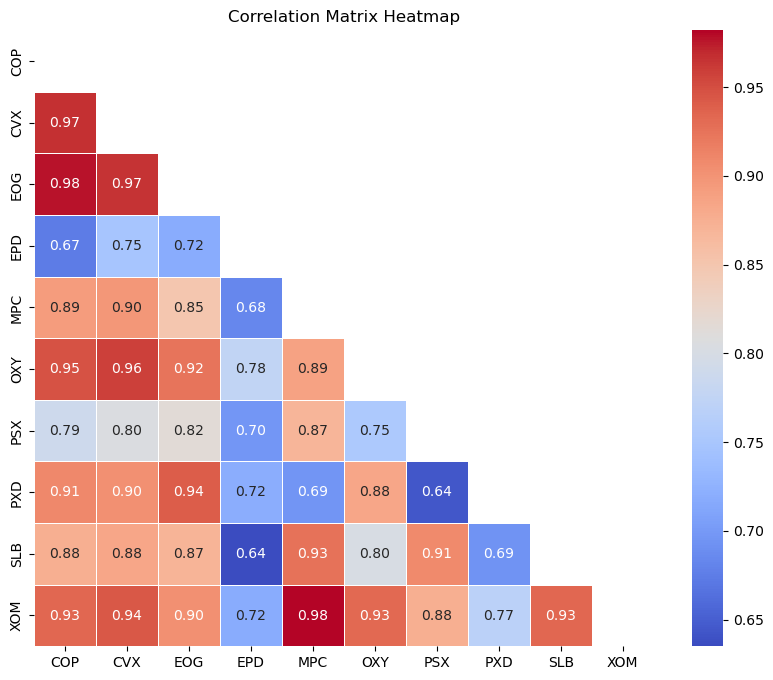

Top 5 Pairs Based on Correlation Score:
         pair  Correlation score
0  (XOM, MPC)           0.981946
1  (EOG, COP)           0.977688
2  (CVX, COP)           0.966087
3  (EOG, CVX)           0.965407
4  (OXY, CVX)           0.958641


In [24]:
# Drop SP500 column for statistical tests
df_train_h_stat = df_train_h.drop(columns='SP500')

corr_matrix_hourly = df_train_h_stat.corr()

# Exclude diagonal and upper triangle
np.fill_diagonal(corr_matrix_hourly.values, np.nan)
mask = np.triu(np.ones_like(corr_matrix_hourly, dtype=bool))
corr_matrix_hourly = corr_matrix_hourly.mask(mask)

# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Find the top 3 pairs based on correlation score
top_pairs_cor_h = (corr_matrix_hourly.abs().stack()
              .sort_values(ascending=False)
              .head(5)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'Correlation score'}))

top_pairs_cor_h['pair'] = top_pairs_cor_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 5 pairs (lowest p-value)
print("Top 5 Pairs Based on Correlation Score:")
print(top_pairs_cor_h[['pair', 'Correlation score']])




### Cointegration test
We are using augmented Engle-Granger two-step cointegration test.
Testing for cointegration. We want as low p-value as possible. Ideally < 2 %.

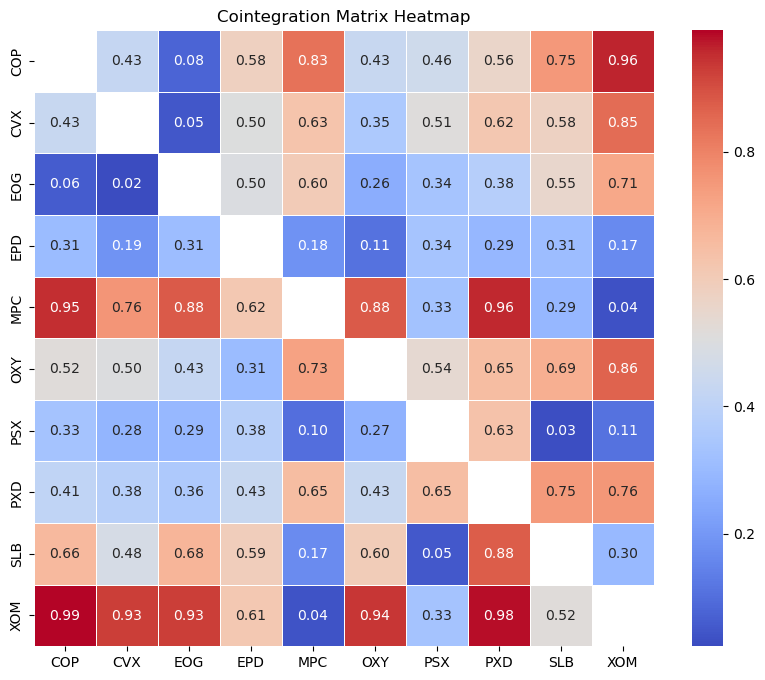

Top 3 Pairs Based on Cointegration Score:
         pair   P-value
0  (EOG, CVX)  0.023346
1  (PSX, SLB)  0.030692
2  (MPC, XOM)  0.037130


In [25]:
columns = df_train_h_stat.columns

# Initialize a matrix to store cointegration test results
coint_matrix_hourly = pd.DataFrame(index=columns, columns=columns)

# Perform cointegration tests for all pairs
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            t,p,_ = ts.coint(df_train_h_stat[col1], df_train_h_stat[col2])
            coint_matrix_hourly.loc[col1, col2] = p

# Transform to numeric 
coint_matrix_hourly = coint_matrix_hourly.apply(pd.to_numeric, errors='coerce')


# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(coint_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cointegration Matrix Heatmap')
plt.show()

# Find the top 3 pairs based on cointegration score
top_pairs_coint_h = (coint_matrix_hourly.abs().stack()
              .sort_values(ascending=True)
              .head(3)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'P-value'}))

top_pairs_coint_h['pair'] = top_pairs_coint_h.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 3 pairs (lowest p-value)
print("Top 3 Pairs Based on Cointegration Score:")
print(top_pairs_coint_h[['pair', 'P-value']])


In [26]:
# Extract pairs from both DataFrames
pairs_df1 = set(top_pairs_cor_h['pair'])
pairs_df2 = set(top_pairs_coint_h['pair'])

# Find common pairs
common_pairs = pairs_df1.intersection(pairs_df2)

# Print common pairs
print("Common Pairs:")
for pair in common_pairs:
    print(pair)

Common Pairs:
('EOG', 'CVX')


After comparing correlation and cointegration pair (XOM,MPC) was drop due to worse cointegration results out of those two pairs. The pair we find in both lists of top cointegrated and correlated is **(EOG,CVX)**.

### Stationarity - Augmented Dickey Fuller test

In [27]:
def stationarity_test(X, cutoff=0.02):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = round(ts.adfuller(X)[1], ndigits=4)
    if pvalue <= cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [28]:
# Check for stationarity in our stocks
for ticker in df_train_h_stat.columns:
    stationarity_test(df_train_h_stat[ticker])

p-value = 0.481 The series COP is likely non-stationary.
p-value = 0.6779 The series CVX is likely non-stationary.
p-value = 0.4 The series EOG is likely non-stationary.
p-value = 0.2183 The series EPD is likely non-stationary.
p-value = 0.8195 The series MPC is likely non-stationary.
p-value = 0.6294 The series OXY is likely non-stationary.
p-value = 0.2847 The series PSX is likely non-stationary.
p-value = 0.3661 The series PXD is likely non-stationary.
p-value = 0.5079 The series SLB is likely non-stationary.
p-value = 0.8703 The series XOM is likely non-stationary.


Our results for stationarity are not the best, but the explenation is that our time horizon is more then 3 years and stocks rose in that time. Since our trades will be short term because of hourly time frame this is not so important and moreover we will be doing pair trading which means that pair's ratio needs to be stationary. So let's check for stationarity in our selected pair's ratio.

In [29]:
# Function that creates df of ratio based on two tickers and data frame provided
# Also returns graph of ration with mean value as horizontal line
def ratio_calculation_and_plot(ticker1, ticker2, df):
    ticker1 = ticker1
    ticker2 = ticker2

    # Calculate ratio
    ratio = df[ticker1]/df[ticker2]
    ratio = pd.Series(ratio, name = f'Ratio {ticker1}/{ticker2}')

    # Plot ratio and mean
    fig = ratio.plot(linestyle='-')
    fig.legend()
    fig.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
    return ratio, fig

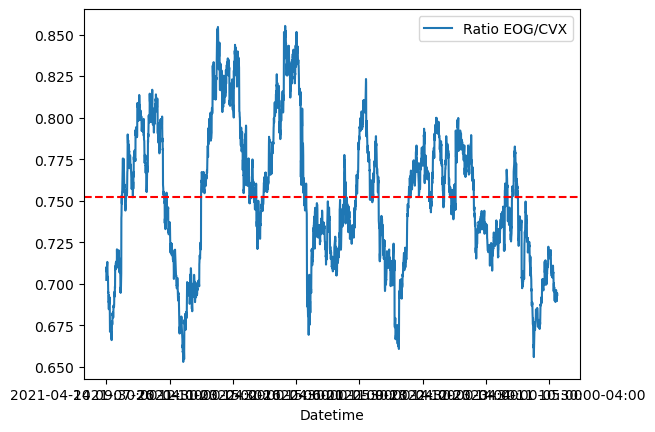

In [30]:
ratio_h, fig = ratio_calculation_and_plot('EOG','CVX',df_train_h_stat)

In [31]:
stationarity_test(ratio_h)

p-value = 0.0154 The series Ratio EOG/CVX is likely stationary.


We can say with 2 % confidence that our pair's ration EOG/CVX is stationary process.


## Daily EDA

In [32]:
# Load csv of train data
df_train_d = pd.read_csv('data/pair_train_daily.csv', index_col=0, parse_dates=True)

# Set index to date column
df_train_d.set_index('Date', inplace=True)

df_train_d.tail()


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/2274091540.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



COP        CVX        EOG        EPD        OXY         PXD  \
Date                                                                            
2016-10-12  34.438953  74.355453  75.499245  15.836151  59.340790  148.010956   
2016-10-13  33.586338  73.365501  75.002869  15.807073  59.260597  145.878906   
2016-10-14  33.203857  73.576591  74.201813  15.638417  58.715302  144.173279   
2016-10-17  32.749668  73.780426  73.652023  15.463948  58.113876  142.870758   
2016-10-18  32.391102  74.093399  73.141541  15.719837  58.194080  142.676926   

                  SLB        XOM        SP500  
Date                                           
2016-10-12  65.748810  61.289021  2139.179932  
2016-10-13  65.821465  60.888065  2132.550049  
2016-10-14  65.651932  60.874012  2132.979980  
2016-10-17  65.377449  60.874012  2126.500000  
2016-10-18  65.708443  61.035793  2139.600098

In [33]:
fig1 = px.line(df_train_d, x=df_train_d.index, y=df_train_d.columns, labels={'value': 'Adjusted Close Price', 'variable': 'Ticker'})
fig1.update_layout(title='Adjusted Daily Close Prices of Selected Stocks and S&P 500',
                  xaxis_title='Date',
                  yaxis_title='Adjusted Close Price')

# Show the interactive plot
fig1.show()

### Correlation test

In [34]:
# Make a copy of dataframe without column SP500 for statistical tests
df_train_d_stat = df_train_d.drop(columns='SP500')

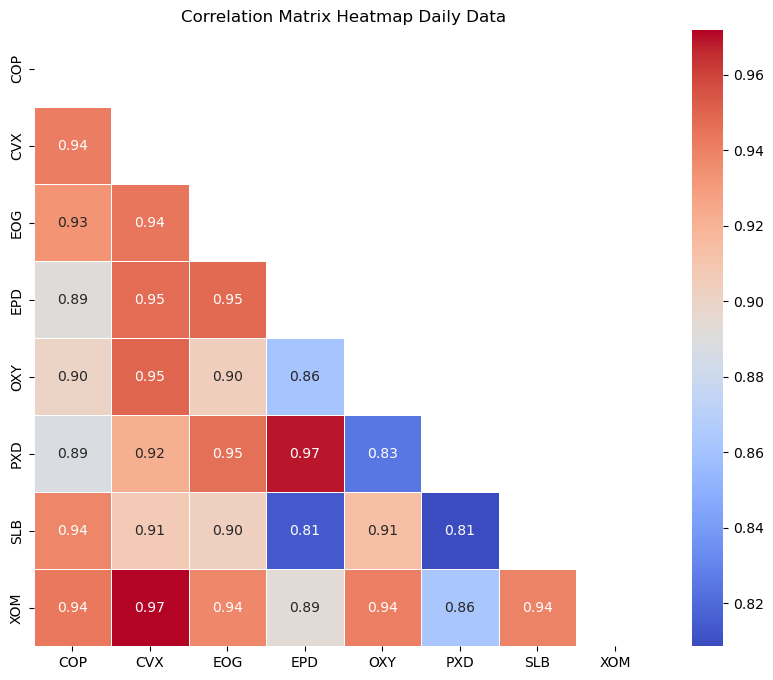

Top 5 Pairs Based on Correlation Score:
         pair  Correlation score
0  (XOM, CVX)           0.971744
1  (PXD, EPD)           0.969016
2  (OXY, CVX)           0.949692
3  (EPD, EOG)           0.948734
4  (EPD, CVX)           0.947308


In [35]:
corr_matrix_daily = df_train_d_stat.corr()


# Exclude diagonal and upper triangle
mask = np.triu(np.ones_like(corr_matrix_daily, dtype=bool))
corr_matrix_daily = corr_matrix_daily.mask(mask)

# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap Daily Data')
plt.show()


# Find the top 3 pairs based on correlation score
top_pairs_cor_d = (corr_matrix_daily.abs().stack()
              .sort_values(ascending=False)
              .head(5)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'Correlation score'}))

top_pairs_cor_d['pair'] = top_pairs_cor_d.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 5 pairs (lowest p-value)
print("Top 5 Pairs Based on Correlation Score:")
print(top_pairs_cor_d[['pair', 'Correlation score']])

### Cointegration test

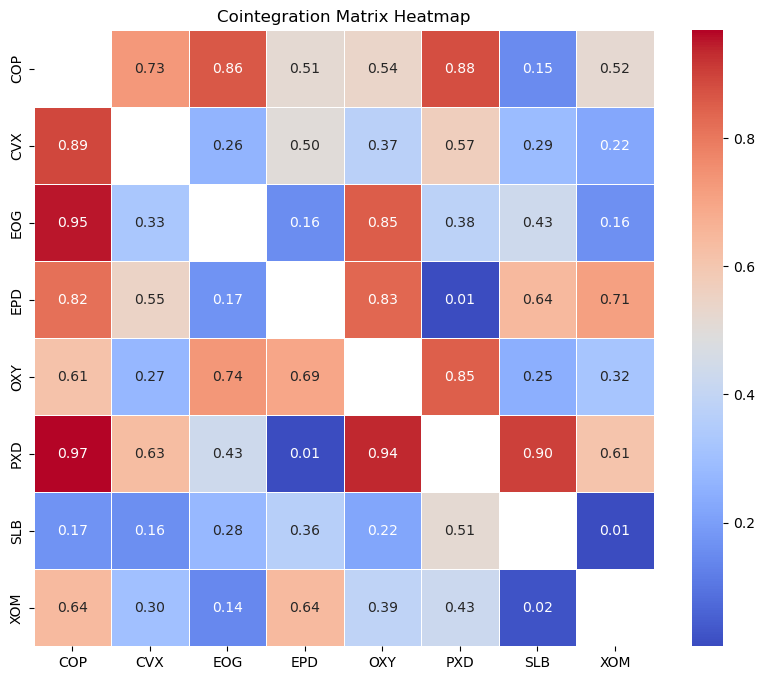

Top 3 Pairs Based on Cointegration Score:
         pair   P-value
0  (EPD, PXD)  0.007029
1  (PXD, EPD)  0.008730
2  (SLB, XOM)  0.008824


In [36]:
columns = df_train_d_stat.columns

# Initialize a matrix to store cointegration test results
coint_matrix_daily = pd.DataFrame(index=columns, columns=columns)

# Perform cointegration tests for all pairs (cointegration test is not a symethrical test)
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            t,p,_ = ts.coint(df_train_d_stat[col1], df_train_d_stat[col2])
            coint_matrix_daily.loc[col1, col2] = p

# Transform to numeric 
coint_matrix_daily = coint_matrix_daily.apply(pd.to_numeric, errors='coerce')


# Plot correlation matric heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(coint_matrix_daily, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Cointegration Matrix Heatmap')
plt.show()

# Find the top 3 pairs based on cointegration score
top_pairs_coint_d = (coint_matrix_daily.abs().stack()
              .sort_values(ascending=True)
              .head(3)
              .reset_index()
              .rename(columns={'level_0': 'Pair1', 'level_1': 'Pair2', 0: 'P-value'}))

top_pairs_coint_d['pair'] = top_pairs_coint_d.apply(lambda row: (row['Pair1'], row['Pair2']), axis=1)

# Print the top 3 pairs (lowest p-value)
print("Top 3 Pairs Based on Cointegration Score:")
print(top_pairs_coint_d[['pair', 'P-value']])

In [37]:
# Extract pairs from both DataFrames
pairs_df1 = set(top_pairs_cor_d['pair'])
pairs_df2 = set(top_pairs_coint_d['pair'])

# Find common pairs
common_pairs = pairs_df1.intersection(pairs_df2)

# Print common pairs
print("Common Pairs:")
for pair in common_pairs:
    print(pair)

Common Pairs:
('PXD', 'EPD')


### Stationarity - Augmented Dickey Fuller test

In [38]:
# Check for stationarity in our stocks
for ticker in df_train_d_stat.columns:
    stationarity_test(df_train_d_stat[ticker])

p-value = 0.4726 The series COP is likely non-stationary.
p-value = 0.8446 The series CVX is likely non-stationary.
p-value = 0.8851 The series EOG is likely non-stationary.
p-value = 0.9224 The series EPD is likely non-stationary.
p-value = 0.6465 The series OXY is likely non-stationary.
p-value = 0.8869 The series PXD is likely non-stationary.
p-value = 0.5251 The series SLB is likely non-stationary.
p-value = 0.7925 The series XOM is likely non-stationary.


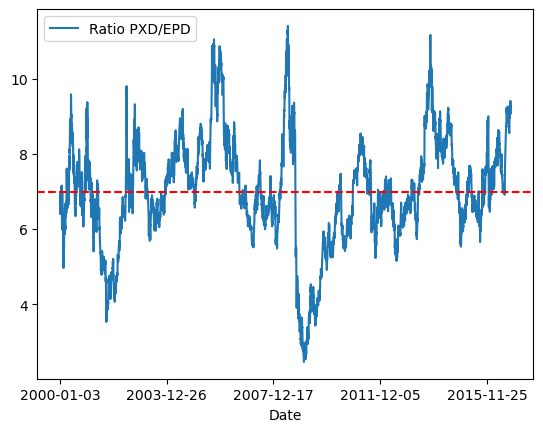

In [39]:
ratio_d, fig_d = ratio_calculation_and_plot('PXD','EPD',df_train_d_stat)

In [40]:
stationarity_test(ratio_d)

p-value = 0.0027 The series Ratio PXD/EPD is likely stationary.


# 4. Strategy

## Hourly Strategy

### Standardization: Z-score

A z-score is the number of standard deviations a data point is from the mean. More importantly, the number of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i} = \frac{x_{i} - \bar{x}}{s}$$

In [41]:
# We lag prices to avoid bias of seeing end of the day prices at the begining of the day
df_eog_cvx = df_train_h_stat[['EOG', 'CVX']].copy()

df_eog_cvx['lag_EOG'] = df_eog_cvx['EOG'].shift(1)

df_eog_cvx['lag_CVX'] = df_eog_cvx['CVX'].shift(1)
df_eog_cvx = df_eog_cvx.dropna()



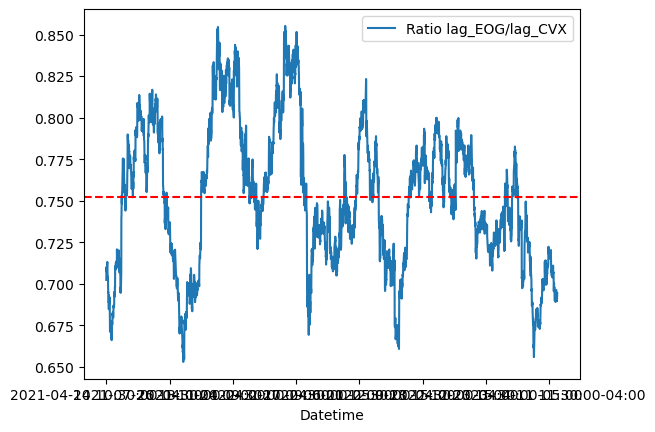

In [42]:
ratio_h_lagged,_ = ratio_calculation_and_plot('lag_EOG','lag_CVX',df_eog_cvx)

In [43]:
# Z score calculation
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [44]:
# Z score calculation with mooving averages
def zscore_mooving(series):
    # Ratios_mavg5 = series.rolling(window=5, center=False).mean()
    ratios_mavg150 = series.rolling(window=150, center=False).mean()
    std_150 = series.rolling(window=150, center=False).std()
    zscore_150 = (series - ratios_mavg150)/std_150
    return zscore_150

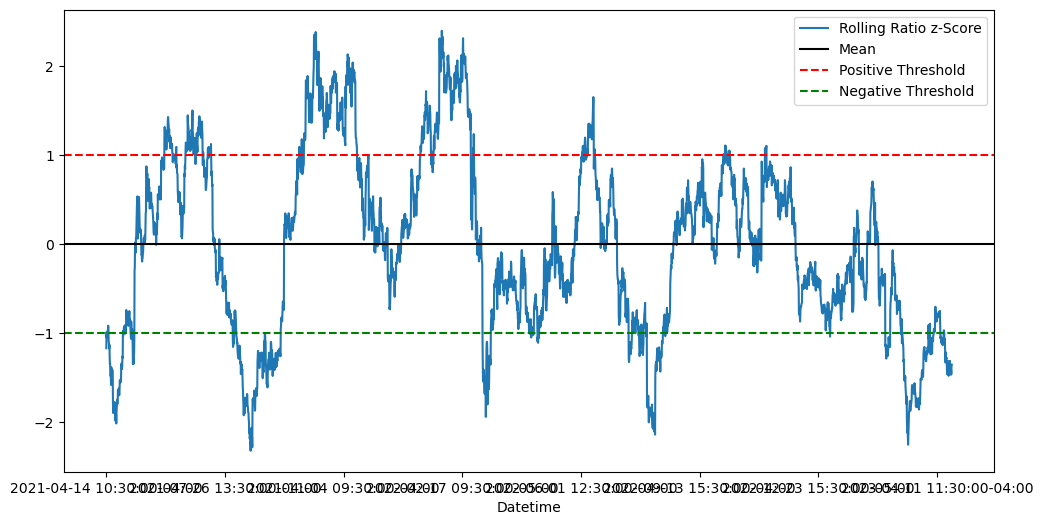

In [45]:
zscore_h = zscore(ratio_h_lagged)
zscore_h.name = f'Z-score {ratio_h.name[-7:]}'


zscore_h.plot(figsize=(12,6))
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean','Positive Threshold', 'Negative Threshold'])

plt.show()

In [46]:
df_ret_h = df_long_h[(df_long_h['ticker'] == "EOG")|(df_long_h['ticker'] == "CVX")]
df_ret_h = df_ret_h.drop(columns='price')

In [47]:
wide_df_h = df_ret_h.pivot(columns='ticker', values=['ret', 'cum_ret'])

# Assuming wide_df is your DataFrame with multi-level columns
wide_df_h.columns = [f'{ticker}_{col}' if col != '' else col for col, ticker in wide_df_h.columns]


In [48]:
zscore_h = pd.DataFrame(zscore_h)

# Combine zscore, and prices lagged in one table
df_eog_cvx = df_eog_cvx[["lag_EOG", "lag_CVX"]]
df_strategy = pd.merge(df_eog_cvx, zscore_h, left_index=True, right_index=True)
df_strategy = pd.merge(df_strategy,wide_df_h,left_index=True, right_index=True)


In [49]:
# Betas
beta_CVX = 1.12
beta_EOG = 1.39

position_encoding = {
    0 : 'no positions',
    1 : 'long on EOG & short on CVX',
    2 : 'long on CVX & short on EOG'}


In [50]:
# This function returns the numbers of shares to trade from each company
# In this case I will fix the number of CVX's shares to 1000 and round up
# The equivalent number of EOG's shares to the closest int. 
def get_number_of_shares(ts1, ts2, time):
  ratio = ts2[time]/ts1[time] * beta_CVX/beta_EOG
  return np.rint(1000*ratio), 1000

In [51]:
def strategy_simulation(ticker1, ticker2, df, upper_threshold, lower_threshold):
    # Portfolio value over time
    # It equals the total plus the position value
    portfolio_value = []

    # Current total
    total = 0
    current_position = 0  # Starts with no position
    
    # Number of shares
    n_EOG = 0 
    n_CVX = 0

    # Stock prices
    ts1 = df[f'lag_{ticker1}']
    ts2 = df[f'lag_{ticker2}']
    
    position_history = []
    # Strategy simulation script
    for i, z in enumerate(df_strategy[f'Z-score {ticker1}/{ticker2}']):
      # If has position check if should quit
      if current_position == 1:
        # Condition to quit long EOG short CVX
        if z >= 0:
          total += ts1[i] * n_EOG
          total -= ts2[i] * n_CVX
          n_EOG = 0
          n_CVX = 0
          current_position = 0
      elif current_position == 2:
        # Condition to quit long CVX short EOG
        if z <= 0:
          total -= ts1[i] * n_EOG
          total += ts2[i] * n_CVX
          n_EOG = 0
          n_CVX = 0
          current_position = 0
    
      # If has no position check if should enter
      # Note that this allows to switch positions
      if current_position == 0:
        # Condition to enter long CVX short EOG
        if z >= upper_threshold:
          n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
          total += ts1[i] * n_EOG
          total -= ts2[i] * n_CVX
          current_position = 2
        # Condition to enter long EOG short CVX
        elif z <= lower_threshold:
          n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
          total -= ts1[i] * n_EOG
          total += ts2[i] * n_CVX
          current_position = 1

      # Register position
      position_history.append(current_position)

      # Compute current portfolio value 
      current_portfolio_value = total
      # If long EOG short CVX
      if current_position == 1:
        current_portfolio_value += n_EOG * ts1[i]
        current_portfolio_value -= n_CVX * ts2[i]
      # If long CVX short EOG
      elif current_position == 2:
        current_portfolio_value -= n_EOG * ts1[i]
        current_portfolio_value += n_CVX * ts2[i]
      # Register current portfolio value
      portfolio_value.append(current_portfolio_value)
    current_position = 0
    total = 0

  # Print('Final portfolio value: %.2F' % portfolio_value[-1])

    # Create data frame of portfolio value
    df_portfolio_value = pd.DataFrame(portfolio_value, columns=['value'])
    df_position_history = pd.DataFrame(position_history, columns=['pos'])
    # Print('Final portfolio value: %.2F' % portfolio_value[-1])
    portfolio_value.clear()
    return df_portfolio_value, df_position_history



In [52]:
def strategy_simulation_fees(ticker1, ticker2, df, upper_threshold, lower_threshold):
    # Portfolio value over time
    portfolio_value = []

    # Returns
    returns = []
    # Current total
    total = 0
    current_position = 0  # Starts with no position
    
    # Number of shares
    n_EOG = 0 
    n_CVX = 0

    # Stock prices
    ts1 = df[f'lag_{ticker1}']
    ts2 = df[f'lag_{ticker2}']
    
    position_history = []
    # Strategy simulation script
    for i, z in enumerate(df[f'Z-score {ticker1}/{ticker2}']):
        # If has position, check if should quit
        if current_position == 1:
            # Condition to quit long EOG short CVX
            if z >= 0:
                total += ts1[i] * n_EOG * (1 - 0.001)  # 0.1% fee for long position
                total -= ts2[i] * n_CVX * (1 + 0.002)  # 0.2% fee for short position
                n_EOG = 0
                n_CVX = 0
                current_position = 0
        elif current_position == 2:
            # Condition to quit long CVX short EOG
            if z <= 0:
                total -= ts1[i] * n_EOG * (1 + 0.001)  # 0.1% fee for long position
                total += ts2[i] * n_CVX * (1 - 0.002)  # 0.2% fee for short position
                n_EOG = 0
                n_CVX = 0
                current_position = 0
    
        # If has no position, check if should enter
        # Note that this allows switching positions
        if current_position == 0:
            # Condition to enter long CVX short EOG
            if z >= upper_threshold:
                n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
                total += ts1[i] * n_EOG * (1 - 0.001)  # 0.1% fee for long position
                total -= ts2[i] * n_CVX * (1 + 0.002)  # 0.2% fee for short position
                current_position = 2
            # Condition to enter long EOG short CVX
            elif z <= lower_threshold:
                n_EOG, n_CVX = get_number_of_shares(ts1=ts1, ts2=ts2, time=i)
                total -= ts1[i] * n_EOG * (1 + 0.001)  # 0.1% fee for long position
                total += ts2[i] * n_CVX * (1 - 0.002)  # 0.2% fee for short position
                current_position = 1

        # Register position
        position_history.append(current_position)

        # Compute current portfolio value 
        current_portfolio_value = total
        # If long EOG short CVX
        if current_position == 1:
            current_portfolio_value += n_EOG * ts1[i] 
            current_portfolio_value -= n_CVX * ts2[i] 
        # If long CVX short EOG
        elif current_position == 2:
            current_portfolio_value -= n_EOG * ts1[i] 
            current_portfolio_value += n_CVX * ts2[i] 
            
        

        if len(portfolio_value) > 0 and portfolio_value[-1] != 0:
            returns.append((current_portfolio_value - portfolio_value[-1]) / portfolio_value[-1])
        else:
            returns.append(0)

        portfolio_value.append(current_portfolio_value)

    current_position = 0
    total = 0

    
    # Create data frame of portfolio value
    df_portfolio_value = pd.DataFrame(portfolio_value, columns=['value'])
    df_position_history = pd.DataFrame(position_history, columns=['pos'])
    df_returns = pd.DataFrame(returns, columns=['daily_return'])
    
    portfolio_value.clear()
    return df_portfolio_value, df_position_history, df_returns


In [53]:
# Create a sequence from -0.5 to -1.5 with step 0.1
lower_threshold = np.linspace(-0.5, -1.5, num=11)
# Create a sequence from 0.5 to 1.5 with step 0.1
upper_threshold = np.linspace(0.5, 1.5, num=11)

# Create pairs: each short assign to each long
pairs = [(l, u) for l in lower_threshold for u in upper_threshold]

In [54]:
# Parameters search
results = {}

# Loop over pairs
for l,u in pairs:
  df_portfolio_value,_, _ = strategy_simulation_fees('EOG', 'CVX', df_strategy, u, l)

  final_value = df_portfolio_value['value'].iloc[-1]
  results[(l,u)] = final_value


/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/1022240767.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/2165283249.py:52: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/2165283249.py:53: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/i

In [55]:
# Print results
for k, v in results.items():
  print(f'{k}: {v:.4f}')

max_key = max(results, key=lambda k: results[k])
max_value = results[max_key]

print(10*'****')

print(f"Max Portfolio Value: {max_value} for parameters {max_key}")

(-0.5, 0.5): 72951.4194
(-0.5, 0.6): 73312.3313
(-0.5, 0.7): 78847.5101
(-0.5, 0.8): 79511.3608
(-0.5, 0.9): 65230.4802
(-0.5, 1.0): 66105.7913
(-0.5, 1.1): 67480.0996
(-0.5, 1.2000000000000002): 54847.6824
(-0.5, 1.3): 57782.3249
(-0.5, 1.4): 60491.8970
(-0.5, 1.5): 61589.8588
(-0.6, 0.5): 73489.0711
(-0.6, 0.6): 73849.9830
(-0.6, 0.7): 79385.1618
(-0.6, 0.8): 80049.0125
(-0.6, 0.9): 65768.1318
(-0.6, 1.0): 66643.4430
(-0.6, 1.1): 68017.7512
(-0.6, 1.2000000000000002): 55385.3341
(-0.6, 1.3): 58319.9765
(-0.6, 1.4): 61029.5487
(-0.6, 1.5): 62127.5105
(-0.7, 0.5): 69802.3492
(-0.7, 0.6): 70163.2611
(-0.7, 0.7): 75698.4399
(-0.7, 0.8): 76362.2906
(-0.7, 0.9): 62081.4100
(-0.7, 1.0): 62956.7212
(-0.7, 1.1): 64331.0294
(-0.7, 1.2000000000000002): 51698.6122
(-0.7, 1.3): 54633.2547
(-0.7, 1.4): 57342.8268
(-0.7, 1.5): 58440.7887
(-0.8, 0.5): 67630.3568
(-0.8, 0.6): 67991.2687
(-0.8, 0.7): 73526.4475
(-0.8, 0.8): 74190.2982
(-0.8, 0.9): 59909.4175
(-0.8, 1.0): 60784.7287
(-0.8, 1.1): 62159.

In [56]:
# Add datetime index to our portfolio value df
df_portfolio_value_max, df_position_history_max, df_returns_max= strategy_simulation_fees('EOG', 'CVX', df_strategy, 0.8, -1.5)
df_portfolio_value_max.index = zscore_h.index
df_position_history_max.index = zscore_h.index
df_returns_max.index = zscore_h.index

df_profit_plot_h = pd.merge(df_portfolio_value_max,df_position_history_max, left_index=True, right_index=True )

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/1022240767.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/2165283249.py:52: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/ipykernel_50166/2165283249.py:53: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/v6/6lgngf0x7vq9rcmn59rgh0tc0000gn/T/i

In [57]:
# How to calculate returns to compare with sp500 in a smart way or any other benchmark?
df_returns_max['cum_ret'] = (1 + df_returns_max['daily_return']).cumprod()

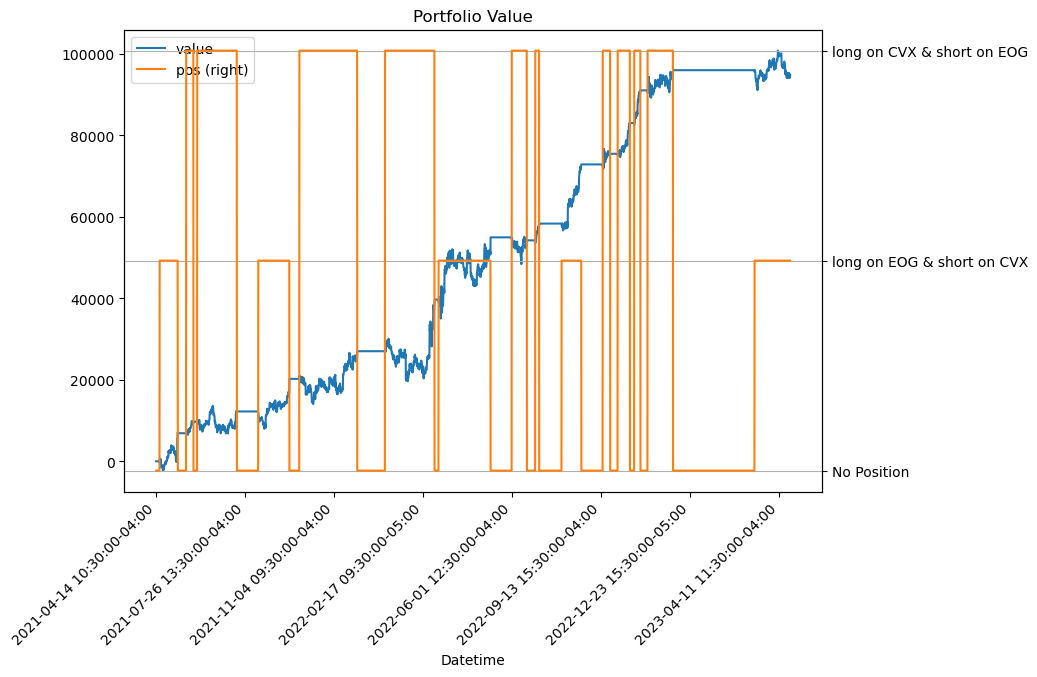

In [58]:
# Plot results
ax = df_profit_plot_h.plot(figsize=(9, 6), secondary_y='pos', title='Portfolio Value', grid=True)

# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

# Rotate x-axis labels at a 45-degree angle
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


In [61]:
n_eog, n_cvx = get_number_of_shares(df_strategy['lag_EOG'], df_strategy['lag_CVX'], time=df_strategy.index[0])
df_portfolio_value_max['benchmark'] = n_eog/10*df_strategy['lag_EOG'] + n_cvx/10*df_strategy['lag_CVX']

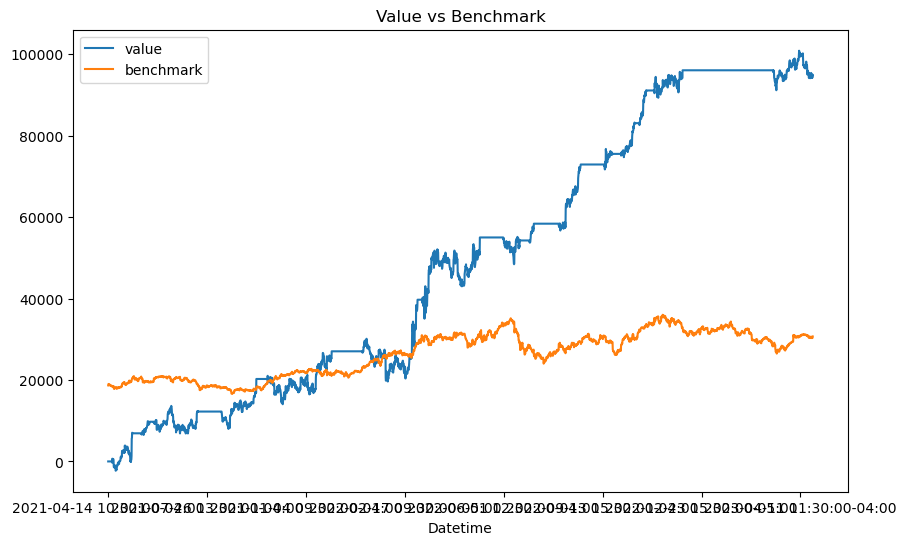

In [62]:
df_portfolio_value_max[['value', 'benchmark']].plot(figsize=(10, 6), title='Value vs Benchmark')

plt.show()



In [160]:
# df_portfolio_value_max['ret_port'] = df_portfolio_value_max['value'].pct_change()
# Compute cumulative returns
# df_portfolio_value_max['cumret_port'] = (1 + df_portfolio_value_max['ret_port']).cumprod()

In [164]:
df_zscore_pos = pd.merge(zscore_h, df_position_history_max, left_index=True, right_index=True)


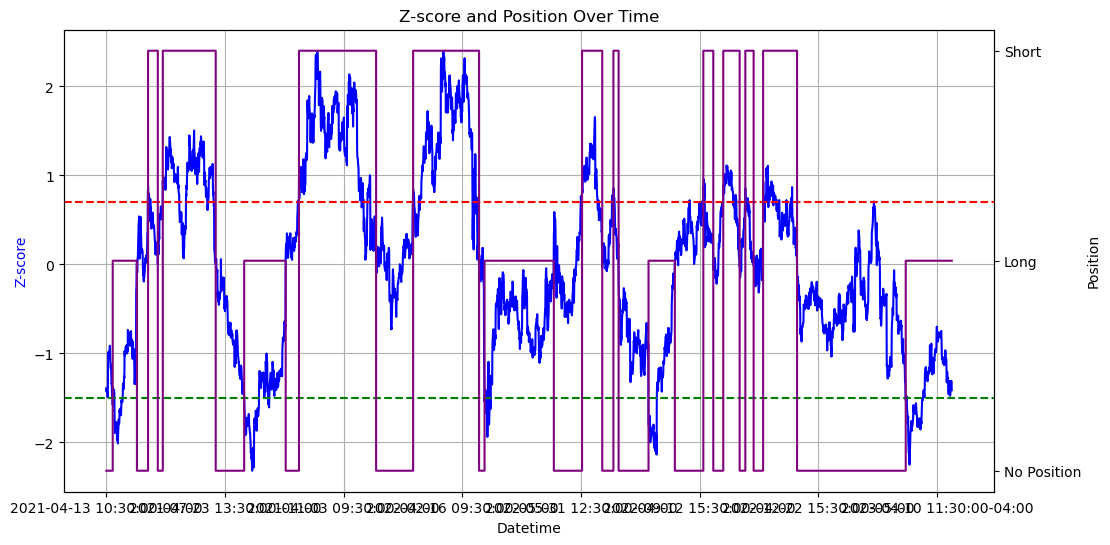

In [165]:
# Plot results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the zscore on the primary y-axis
df_zscore_pos['Z-score EOG/CVX'].plot(ax=ax1, color='blue', label='Z-score', grid=True)
ax1.set_ylabel('Z-score', color='blue')

# Add horizontal lines to the primary y-axis
ax1.axhline(y=0.7, color='red', linestyle='--', label='Upper Threshold')
ax1.axhline(y=-1.5, color='green', linestyle='--', label='Lower Threshold')

# Overlay a secondary y-axis for position
ax2 = ax1.twinx()
ax2.step(df_zscore_pos.index, df_zscore_pos['pos'], where='post', color='purple', label='Position')

# Set y-axis ticks and labels for the secondary axis
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['No Position', 'Long', 'Short'])

ax2.set_ylabel('Position')

plt.title('Z-score and Position Over Time')
plt.show()

In [166]:
df_cvxeog = df_strategy[['lag_EOG','lag_CVX']]
df_cvxeog_pos = pd.merge(df_cvxeog, df_position_history_max, left_index=True, right_index=True)

([<matplotlib.axis.YTick at 0x16c2fe210>,
 [Text(1, 0, 'No Position'),
  Text(1, 1, 'long on EOG & short on CVX'),
  Text(1, 2, 'long on CVX & short on EOG')])

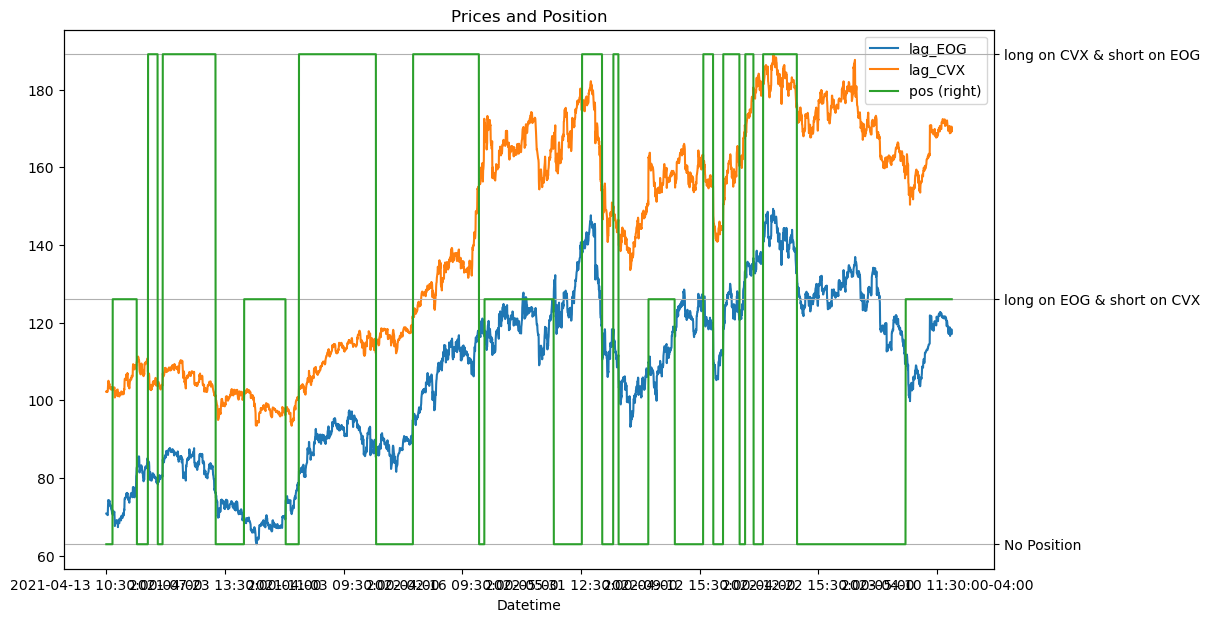

In [167]:
df_cvxeog_pos.plot(figsize=(12,7), secondary_y ='pos', title='Prices and Position', grid=True)
# Set y-axis ticks and labels
plt.yticks([0, 1, 2], ['No Position', position_encoding[1], position_encoding[2]])

## Daily Strategy

### Standardization: Z-score

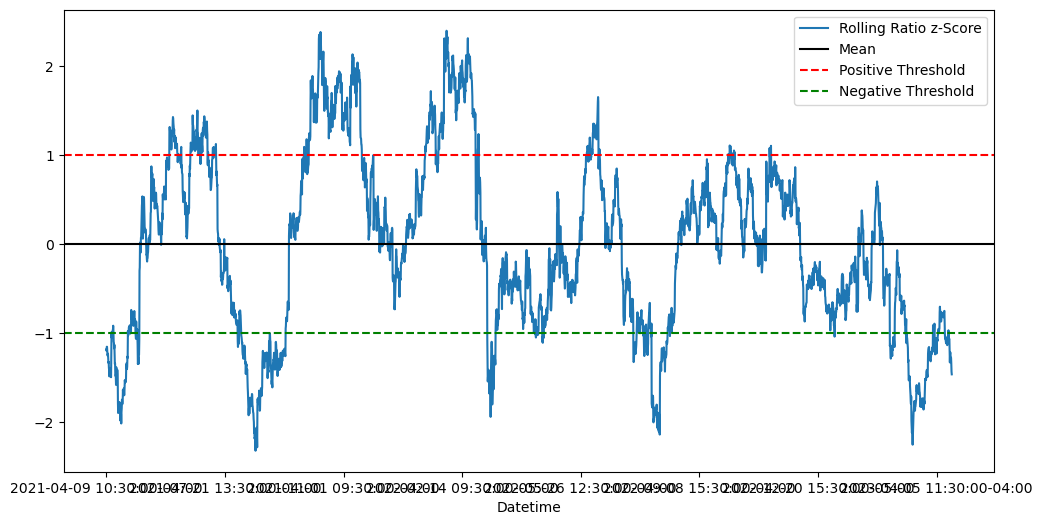

In [48]:
zscore_d = zscore(ratio_d)
zscore_d.name = f'Z-score {ratio_d.name[-7:]}'


zscore_d.plot(figsize=(12,6))
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean','Positive Threshold', 'Negative Threshold'])

plt.show()

## Financial Report

### Hourly Financial Report

In [177]:
# Title
print('_________Portfolio report_________\n\n')

# Printing the final value of the portfolio
final_value = df_portfolio_value_max['value'].iloc[-1]
print(f'Final value:           $ {final_value:.2f} \n')

# Printing the maximum and minimum values of the portfolio
max_value = df_portfolio_value_max['value'].max()
min_value = df_portfolio_value_max['value'].min()
print(f'Max value:             $ {max_value:.2f}')
print(f'Min value:             $ {min_value:.2f}\n')

# Printing expected gain, max gain, and max loss
expected_gain = np.mean(np.diff(df_portfolio_value_max['value']))
max_gain = np.max(np.diff(df_portfolio_value_max['value']))
max_loss = np.min(np.diff(df_portfolio_value_max['value']))
print(f'Expected gain:         $ {expected_gain:.2f}')
print(f'Max gain:              $ {max_gain:.2f}')
print(f'Max loss:              $ {max_loss:.2f}\n')

# Printing max cumulated loss and volatility (standard deviation)
cumulated_loss = np.min([np.min(df_portfolio_value_max['value'][i:]) - np.max(df_portfolio_value_max['value'][:i]) for i in range(1, len(df_portfolio_value_max)-1)])
volatility = np.std(np.diff(df_portfolio_value_max['value']))
print(f'Max cumulated loss:    $ {cumulated_loss:.2f}')
print(f'Volatility (std):      $ {volatility:.2f}\n')


_________Portfolio report_________


Final value:           $ 94592.11 

Max value:             $ 100840.06
Min value:             $ -2280.01

Expected gain:         $ 26.55
Max gain:              $ 4780.89
Max loss:              $ -5731.07

Max cumulated loss:    $ -10486.26
Volatility (std):      $ 549.60

